In [2]:
import torch
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from torchvision.datasets import MNIST
from torchvision import transforms
from sklearn.metrics import roc_curve, roc_auc_score

In [31]:
PROJ_ROOT = '/Users/mloui/Documents/STAR/SOFAR'

In [88]:
# Quickscat normal - use for training
all_data = np.loadtxt(f'{PROJ_ROOT}/data/NASA_R3/raw_telemetry/quickscat/normal_quickscat.csv',
                 delimiter=",", dtype=str)
print(all_data.shape)

times = all_data[1:,0]
var_names = all_data[0,1:]
data = all_data[1:,1:].astype(float)

print(times.shape)
print(var_names.shape)
print(data.shape)

data_size = data.shape[1]
print(data_size)

# Normalize and convert to tensor
min_val = np.amin(data)
max_val = np.amax(data)
data = (data-min_val)/(max_val-min_val)
print(np.amin(data))
print(np.amax(data))

dataset = torch.from_numpy(data)
dataset = dataset.type('torch.FloatTensor')
print(dataset.dtype)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Dataloader
batchsize = 64
loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                     batch_size = batchsize,
                                     shuffle = True)
val_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                     batch_size = batchsize,
                                     shuffle = True)

(500965, 11)
(500964,)
(10,)
(500964, 10)
10
0.0
1.0
torch.float32


In [41]:
# Simulated normal data

df = pd.read_csv(f'{PROJ_ROOT}/data/simulated/sim_train1.csv')
data = df.to_numpy()[:,:-3]
data_size = data.shape[1]
print(data_size)
print(data.shape)
print(data[10])

# Normalize and convert to tensor
min_vals = np.amin(data, axis=0)
max_vals = np.amax(data, axis=0)
min_arr = np.repeat(np.expand_dims(min_vals, axis=0), len(data), axis=0)
max_arr = np.repeat(np.expand_dims(max_vals, axis=0), len(data), axis=0)
data = (data-min_arr)/(max_arr-min_arr)
print(np.amin(data))
print(np.amax(data))

dataset = torch.from_numpy(data)
dataset = dataset.type('torch.FloatTensor')
print(dataset.dtype)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Dataloader
batchsize = 64
loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                     batch_size = batchsize,
                                     shuffle = True)
val_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                     batch_size = batchsize,
                                     shuffle = True)

13
(540000, 13)
[ 4.27489169  1.61377738  3.28712251  7.9413146   0.25554456  0.63067393
  7.96395936  0.26761411  0.20830884 -0.51720671  0.15783271  0.18073429
 10.        ]
0.0
1.0
torch.float32


In [42]:
# AE object
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(data_size, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 28),
            torch.nn.ReLU(),
            torch.nn.Linear(28, 8),
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(8, 28),
            torch.nn.ReLU(),
            torch.nn.Linear(28, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, data_size),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [47]:
# Model initialization
model = AE()
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss(reduction='sum')
 
# Using an Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-5)

In [48]:
# Training
epochs = 20
outputs = []
epoch_losses = []
epoch_val_losses = []

bar = tqdm.tqdm(total=epochs)
for epoch in range(epochs):
    #model.train()
    epoch_loss = 0
    cnt = 0
    for rows in loader:

        #rows, _ = d #MNIST
        
        # Output of Autoencoder
        reconstructed = model(rows)

        # Calculating the loss function
        loss = loss_function(reconstructed, rows)

        # The gradients are set to zero
        # The gradient is computed and stored
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        cnt += 1
 
    avg_epoch_loss = epoch_loss/cnt
    epoch_losses.append(avg_epoch_loss)
        
    # Get validation loss
    #model.eval()
    epoch_val_loss = 0
    cnt = 0
    for rows in val_loader:
        val_reconstructed = model(rows)
        val_loss = loss_function(val_reconstructed, rows)
        epoch_val_loss += val_loss.item()
        cnt += 1
    avg_val_loss = epoch_val_loss/cnt
    epoch_val_losses.append(avg_val_loss)
    
    print(f'Loss: {avg_epoch_loss} || Validation loss: {avg_val_loss}')
    outputs.append((epoch, rows, reconstructed))
    bar.update()
bar.close()

  5%|██▏                                         | 1/20 [00:24<07:41, 24.27s/it]

Loss: 3.0906384177967214 || Validation loss: 2.379025274963971


 10%|████▍                                       | 2/20 [00:46<07:00, 23.36s/it]

Loss: 2.3114440402024106 || Validation loss: 2.1341743813471696


 15%|██████▌                                     | 3/20 [01:10<06:40, 23.57s/it]

Loss: 2.0883318949666796 || Validation loss: 2.0946062159999204


 20%|████████▊                                   | 4/20 [01:33<06:10, 23.15s/it]

Loss: 2.050328404088184 || Validation loss: 2.052859463348472


 25%|███████████                                 | 5/20 [01:55<05:41, 22.79s/it]

Loss: 2.023288458093117 || Validation loss: 2.0230099248043487


KeyboardInterrupt: 

In [45]:
torch.save(model.state_dict(), f'{PROJ_ROOT}/models/ae2.pt')

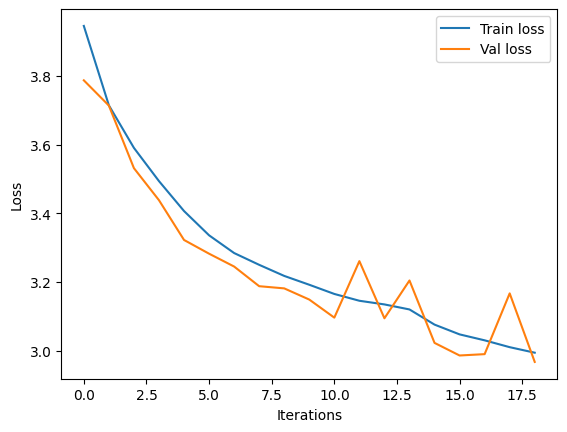

In [46]:
# Plotting the last 100 values
plt.plot(epoch_losses[1:], label='Train loss')
plt.plot(epoch_val_losses[1:], label='Val loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
# Optional load saved model
model = AE()
model.load_state_dict(torch.load(f'{PROJ_ROOT}/models/ae.pt'))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mloui/Documents/STAR/SOFAR/models/ae.pt'

In [92]:
# Quickscat fault - test reconstruction error
fault_data = np.loadtxt(f'{PROJ_ROOT}/data/NASA_R3/raw_telemetry/quickscat/fault_quickscat.csv',
                 delimiter=",", dtype=str)
print(fault_data.shape)

f_times = fault_data[1:,0]
f_var_names = fault_data[0,1:]
f_data_orig = fault_data[1:,1:].astype(float)

print(f_times.shape)
print(f_var_names.shape)
print(f_data_orig.shape)

# Normalize and convert to tensor
f_min_val = np.amin(f_data_orig)
f_max_val = np.amax(f_data_orig)
f_data = (f_data_orig-f_min_val)/(f_max_val-f_min_val)

f_dataset = torch.from_numpy(f_data)
f_dataset = f_dataset.type('torch.FloatTensor')
print(f_dataset.dtype)

# Dataloader
f_batchsize = 1
f_loader = torch.utils.data.DataLoader(dataset = f_dataset,
                                     batch_size = f_batchsize,
                                     shuffle = False)

(104545, 11)
(104544,)
(10,)
(104544, 10)
torch.float32


In [93]:
model.eval()
rec_errs = []
max_err = []
diffs = []
outputs = []

bar = tqdm.tqdm(total=len(f_dataset))
for x in f_loader:
    with torch.no_grad():
        y = model(x)
        outputs.append(y)
        #MSE
        err = torch.sum((x-y)*(x-y)).item()
        err = err/data_size
        rec_errs.append(err)
        diff = np.absolute(np.array(x-y))
        diffs.append(diff)
        max_err.append(np.amax(diff))
    bar.update()
bar.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104544/104544 [00:13<00:00, 7469.13it/s]


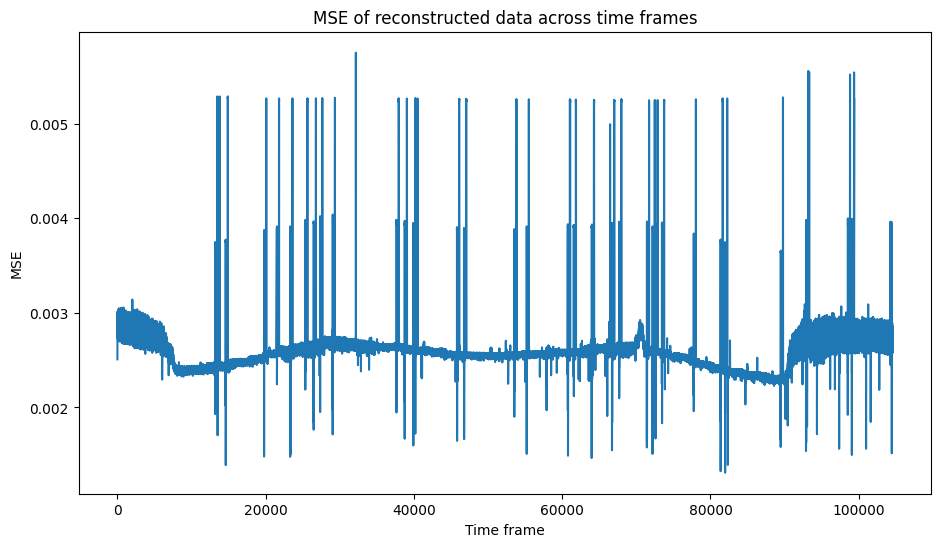

In [94]:
figure(figsize=(11,6))
plt.plot(rec_errs)
plt.title('MSE of reconstructed data across time frames')
plt.xlabel('Time frame')
plt.ylabel('MSE')
plt.show()

In [89]:
'''
figure(figsize=(11,6))
plt.plot(max_err)
plt.title('Maximum mnemonic error of reconstructed data across time frames')
plt.xlabel('Time frame')
plt.ylabel('Maximum mnemonic error')
plt.show()
'''

"\nfigure(figsize=(11,6))\nplt.plot(max_err)\nplt.title('Maximum mnemonic error of reconstructed data across time frames')\nplt.xlabel('Time frame')\nplt.ylabel('Maximum mnemonic error')\nplt.show()\n"

In [97]:
rec_errs = np.array(rec_errs)
diffs = np.array(diffs).squeeze()

# Sorting the MSE error
top_n = np.argsort(rec_errs)
ind = top_n[-20]
print(ind,'\n')
print('MSE')
print(rec_errs[ind],'\n')
print('Data')
print(f_data_orig[ind],'\n')
#print(f_data[ind],'\n')
#print(outputs[ind],'\n')
print('Reconstruction Diff')
print(diffs[ind],'\n')
print('Max mnemonic')
print(f'{f_var_names[np.argmax(diffs[ind])]}: {max_err[ind]}')

#figure(figsize=(11,6))
#plt.plot(rec_errs)
#plt.plot()

93306 

MSE
0.005297926813364029 

Data
[  0.          33.98019969  33.91999969  34.09999968 300.
   0.           0.           0.           0.          11.87016   ] 

Reconstruction Diff
[0.06708108 0.05153415 0.05152597 0.05139689 0.01547313 0.09769052
 0.09731723 0.09776817 0.09111612 0.05841917] 

Max mnemonic
TRW1MT_(C)_max: 0.09776817262172699


In [141]:
# Get locations above an MSE threshold 
thres = 0.0035
pred_faults = (rec_errs>thres).astype(int)
print(pred_faults.shape)
print(f'{np.sum(pred_faults)} faults predicted')

(104544,)
1271 faults predicted


In [118]:
# Load GT
gt_f_data = pd.read_csv(f'{PROJ_ROOT}/data/NASA_R3/raw_telemetry/quickscat/fault_quickscat_gt.csv')
gt_faults = np.array(gt_f_data['Fault']).astype(int)
print(gt_faults.shape)
print(f'{np.sum(gt_faults)} faults in ground truth')

(104544,)
1269 faults in ground truth


In [147]:
# Compare prediction to GT

# Accuracy
compare = pred_faults == gt_faults
acc = np.sum(compare)/len(compare)
print(f'Accuracy = {acc}')

# True positive: when there truly is a fault, how often does it predict there is a fault?
# TP = (pred_fault == 1) when (gt_fault == 1)
compare_tp = pred_faults[gt_faults==1]
tp = np.sum(compare_tp==1)/len(compare_tp)
print(f'True Positive = {tp}')

# False positive: when there truly is not a fault, how often does it incorrectly predict a fault?
# TP = (pred_fault == 1) when gt_fault == 0
compare_fp = pred_faults[gt_faults==0]
fp = np.sum(compare_fp==1)/len(compare_fp)
print(f'False Positive = {fp}')

# True negative: when there truly is not a fault, how often does it predict there is no fault?
compare_tn = pred_faults[gt_faults==0]
tn = np.sum(compare_tn==0)/len(compare_tn)
print(f'True Negative = {tn}')

# False negative: when there truly is a fault, how often does it incorrectly predict there is no fault?
compare_fn = pred_faults[gt_faults==1]
fn = np.sum(compare_fn==0)/len(compare_fn)
print(f'False Negative = {fn}')

Accuracy = 0.9999617385981022
True Positive = 0.9992119779353822
False Positive = 2.9048656499636893e-05
True Negative = 0.9999709513435003
False Negative = 0.0007880220646178094


In [167]:
# ROC curve
thresholds = np.linspace(np.amin(rec_errs), np.amax(rec_errs), 100)
TPR = []
FPR = []
TP_list = []
FP_list = []
TN_list = []
FN_list = []
for t in thresholds:
    pred_faults = (rec_errs>t).astype(int)
    # TPR = TP/(TP+FN)
    compare_tp = pred_faults[gt_faults==1]
    tp = np.sum(compare_tp==1)/len(compare_tp)
    TP_list.append(tp)
    compare_fn = pred_faults[gt_faults==1]
    fn = np.sum(compare_fn==0)/len(compare_fn)
    FN_list.append(fn)
    TPR.append(tp/(tp+fn))
    
    # FPR = FP/(FP+TN)
    compare_fp = pred_faults[gt_faults==0]
    fp = np.sum(compare_fp==1)/len(compare_fp)
    FP_list.append(fp)
    compare_tn = pred_faults[gt_faults==0]
    tn = np.sum(compare_tn==0)/len(compare_tn)
    TN_list.append(tn)
    FPR.append(fp/(fp+tn))

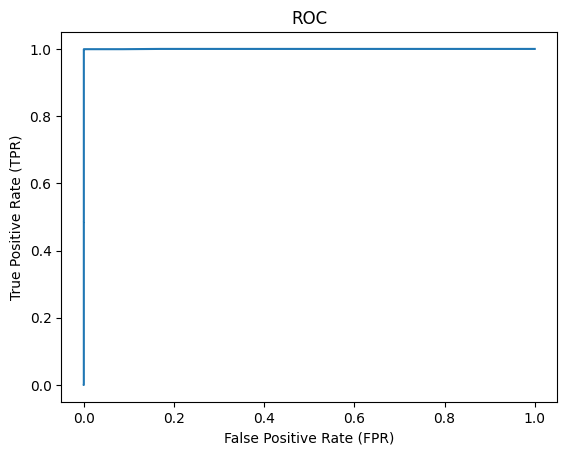

In [168]:
plt.plot(FPR, TPR)
plt.title('ROC')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

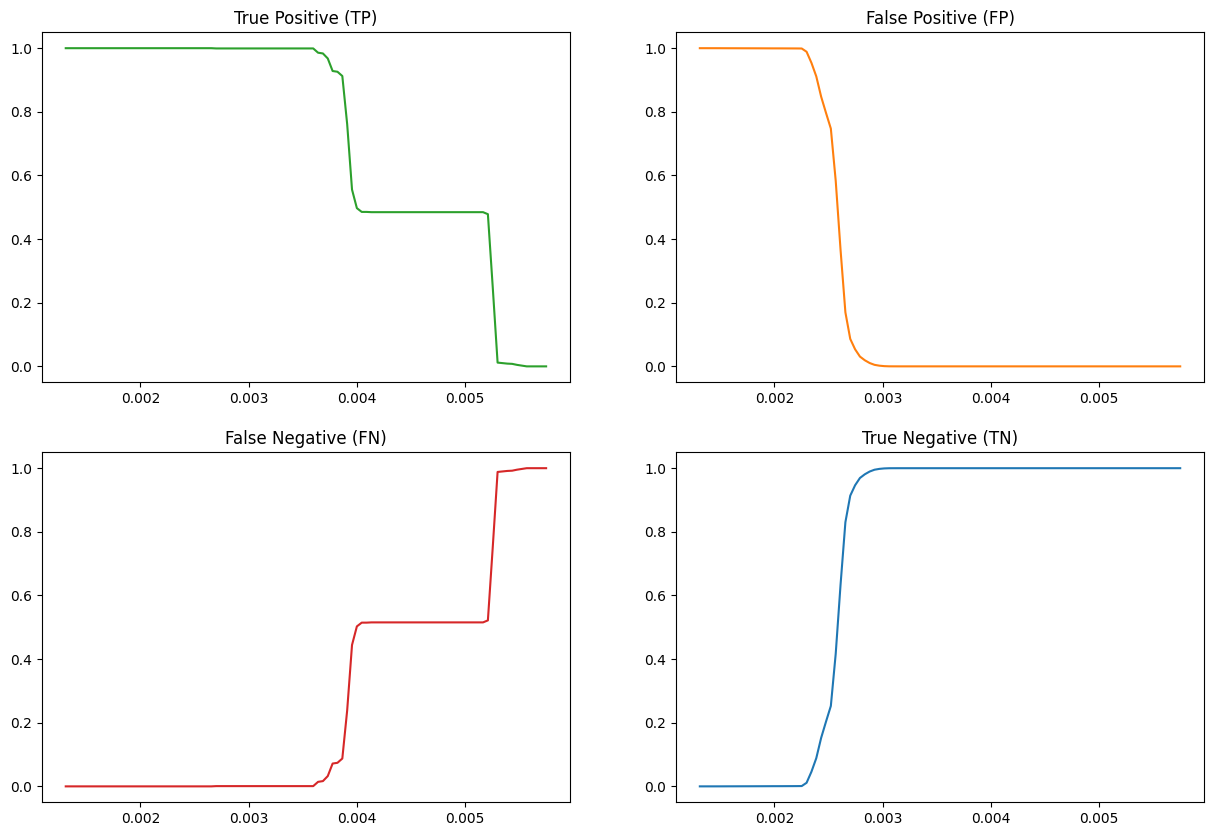

In [203]:
fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(15)
ax[0,0].plot(thresholds, TP_list, label='TP', color='tab:green')
ax[0,0].set_title('True Positive (TP)')
ax[0,1].plot(thresholds, FP_list, label='FP', color='tab:orange')
ax[0,1].set_title('False Positive (FP)')
ax[1,0].plot(thresholds, FN_list, label='FN', color='tab:red')
ax[1,0].set_title('False Negative (FN)')
ax[1,1].plot(thresholds, TN_list, label='TN', color='tab:blue')
ax[1,1].set_title('True Negative (TN)')
plt.show()

### Use sklearn

In [226]:
print(rec_errs[0:10])

[0.00250886 0.00276732 0.00278233 0.00276202 0.00275726 0.00275916
 0.00277687 0.0027664  0.00276403 0.00276162]


In [217]:
fpr, tpr, thres = roc_curve(gt_faults, rec_errs)

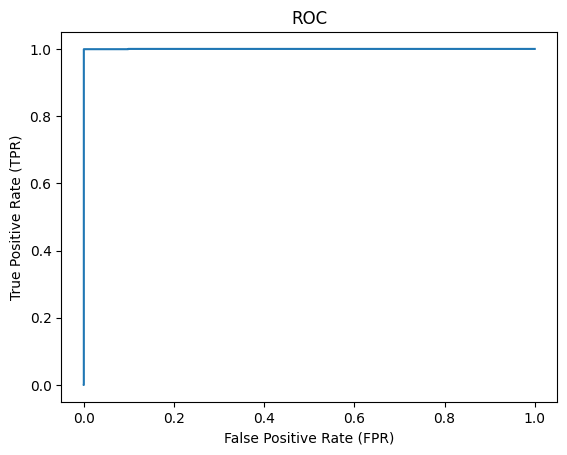

In [221]:
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

In [223]:
# Calculate AUC
auc = roc_auc_score(gt_faults, rec_errs)
print(f'AUC: {auc}')

AUC: 0.9999028087044487
